# Setup

In [1]:
# Define Parameters
batch_size = 128
epochs = 200
task = 'Informativeness_Classification'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torchvision.transforms as transforms
import warnings
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = torch.device("cuda:0")
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
if_train_path = '/work/u9562361/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_train_final.tsv'
if_test_path = '/work/u9562361/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_test_final.tsv'
if_dev_path = '/work/u9562361/crisis_vision_benchmarks/tasks/informative/consolidated/consolidated_info_dev_final.tsv'

train_label = pd.read_table(if_train_path)
test_label = pd.read_table(if_test_path)
dev_label = pd.read_table(if_dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(48186, 4)
(8477, 4)
(3054, 4)


In [4]:
class_label_map = {"informative": 1, "not_informative": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('/work/u9562361/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.resize((224, 224))
            img = img.convert("RGB")
            img = np.array(img, dtype=np.float32) / 255.0
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

In [5]:
X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

 88%|████████▊ | 42577/48186 [20:33<03:28, 26.87it/s]

Error opening image: /work/u9562361/crisis_vision_benchmarks/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/damaged_infrastructure/images/wreckedcar_2017-02-23_21-15-25.jpg - image file is truncated (0 bytes not processed)


100%|██████████| 48186/48186 [23:49<00:00, 33.70it/s]


torch.Size([3, 224, 224])
(48185, 3, 224, 224)


100%|██████████| 48185/48185 [00:00<00:00, 465295.60it/s]


(48185,)


100%|██████████| 8477/8477 [04:18<00:00, 32.76it/s]


torch.Size([3, 224, 224])
(8477, 3, 224, 224)


100%|██████████| 8477/8477 [00:00<00:00, 452286.10it/s]


(8477,)


100%|██████████| 3054/3054 [01:35<00:00, 31.84it/s]


torch.Size([3, 224, 224])
(3054, 3, 224, 224)


100%|██████████| 3054/3054 [00:00<00:00, 448712.80it/s]

(3054,)


In [6]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

# ResNet50_pretrained

In [7]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [8]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [9]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [10]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.3527 - accuracy: 84.06% - val_loss: 0.3423 - val_accuracy: 84.96% - time: 161.95s
Epoch 2/100 - loss: 0.2318 - accuracy: 90.60% - val_loss: 0.3344 - val_accuracy: 85.56% - time: 161.86s
Epoch 3/100 - loss: 0.1500 - accuracy: 94.49% - val_loss: 0.3707 - val_accuracy: 85.27% - time: 162.06s
Epoch 4/100 - loss: 0.0847 - accuracy: 97.34% - val_loss: 0.4164 - val_accuracy: 84.98% - time: 162.09s
Epoch 5/100 - loss: 0.0555 - accuracy: 98.39% - val_loss: 0.4616 - val_accuracy: 84.57% - time: 161.83s
Epoch 6/100 - loss: 0.0388 - accuracy: 98.85% - val_loss: 0.4904 - val_accuracy: 84.74% - time: 162.02s
Epoch 7/100 - loss: 0.0336 - accuracy: 99.00% - val_loss: 0.5091 - val_accuracy: 84.94% - time: 162.08s
Epoch 8/100 - loss: 0.0282 - accuracy: 99.11% - val_loss: 0.5164 - val_accuracy: 85.05% - time: 162.26s
Epoch 9/100 - loss: 0.0236 - accuracy: 99.21% - val_loss: 0.5592 - val_accuracy: 85.24% - time: 161.98s
Epoch 10/100 - loss: 0.0231 - accuracy: 99.20% - val_loss: 0.561

Epoch 80/100 - loss: 0.0070 - accuracy: 99.68% - val_loss: 0.6698 - val_accuracy: 85.38% - time: 162.83s
Epoch 81/100 - loss: 0.0070 - accuracy: 99.68% - val_loss: 0.6649 - val_accuracy: 85.30% - time: 162.79s
Epoch 82/100 - loss: 0.0071 - accuracy: 99.67% - val_loss: 0.6675 - val_accuracy: 85.08% - time: 162.76s
Epoch 83/100 - loss: 0.0071 - accuracy: 99.67% - val_loss: 0.6644 - val_accuracy: 85.12% - time: 162.70s
Epoch 84/100 - loss: 0.0071 - accuracy: 99.68% - val_loss: 0.6664 - val_accuracy: 85.09% - time: 162.72s
Epoch 85/100 - loss: 0.0072 - accuracy: 99.67% - val_loss: 0.6626 - val_accuracy: 85.21% - time: 162.87s
Epoch 86/100 - loss: 0.0072 - accuracy: 99.67% - val_loss: 0.6687 - val_accuracy: 85.30% - time: 162.85s
Epoch 87/100 - loss: 0.0071 - accuracy: 99.67% - val_loss: 0.6674 - val_accuracy: 85.18% - time: 162.72s
Epoch 88/100 - loss: 0.0073 - accuracy: 99.67% - val_loss: 0.6739 - val_accuracy: 85.16% - time: 162.91s
Epoch 89/100 - loss: 0.0073 - accuracy: 99.68% - val_lo

In [11]:
print(task + '_ResNet50_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_pretrained Classification Report:')
print(cr)

Informativeness_Classification_ResNet50_pretrained Performance:
Accuracy : 85.69%
F1-Score : 85.51%
Informativeness_Classification_ResNet50_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      5063
           1       0.85      0.77      0.81      3414

    accuracy                           0.85      8477
   macro avg       0.85      0.84      0.84      8477
weighted avg       0.85      0.85      0.85      8477



## Visualize Results & Confusion Matrix

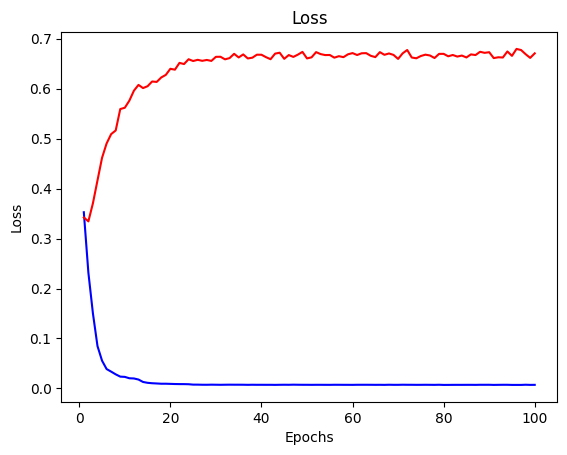

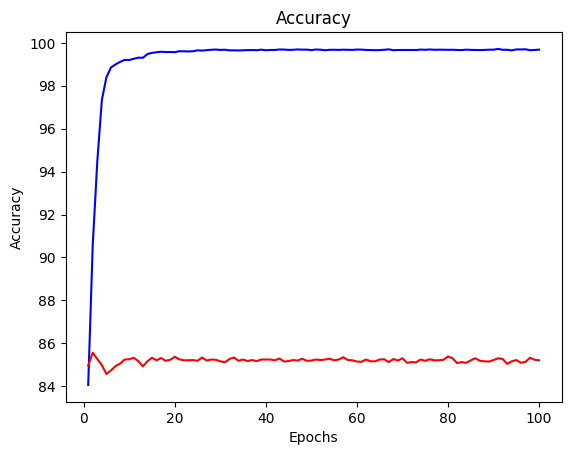

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Informativeness_Classification_ResNet50_pretrained Confusion Matrix:

informative: 1, not_informative: 0


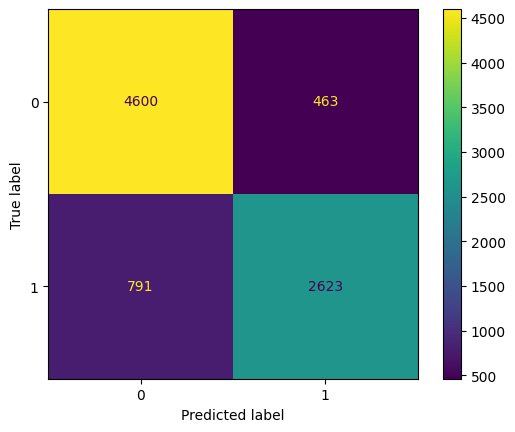

In [13]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet50_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_pretrained

In [14]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [15]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [16]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [17]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.5188 - accuracy: 74.69% - val_loss: 0.4777 - val_accuracy: 78.39% - time: 138.10s
Epoch 2/100 - loss: 0.3825 - accuracy: 83.03% - val_loss: 0.4110 - val_accuracy: 81.63% - time: 137.88s
Epoch 3/100 - loss: 0.3350 - accuracy: 85.50% - val_loss: 0.3795 - val_accuracy: 83.15% - time: 137.93s
Epoch 4/100 - loss: 0.3077 - accuracy: 86.84% - val_loss: 0.3629 - val_accuracy: 84.12% - time: 138.10s
Epoch 5/100 - loss: 0.2861 - accuracy: 87.84% - val_loss: 0.3542 - val_accuracy: 84.46% - time: 137.83s
Epoch 6/100 - loss: 0.2705 - accuracy: 88.40% - val_loss: 0.3467 - val_accuracy: 84.72% - time: 137.91s
Epoch 7/100 - loss: 0.2558 - accuracy: 89.27% - val_loss: 0.3422 - val_accuracy: 85.03% - time: 137.81s
Epoch 8/100 - loss: 0.2427 - accuracy: 89.78% - val_loss: 0.3384 - val_accuracy: 85.25% - time: 137.87s
Epoch 9/100 - loss: 0.2301 - accuracy: 90.34% - val_loss: 0.3378 - val_accuracy: 85.22% - time: 137.79s
Epoch 10/100 - loss: 0.2181 - accuracy: 90.96% - val_loss: 0.336

Epoch 80/100 - loss: 0.1104 - accuracy: 95.63% - val_loss: 0.3939 - val_accuracy: 85.56% - time: 137.85s
Epoch 81/100 - loss: 0.1116 - accuracy: 95.69% - val_loss: 0.3922 - val_accuracy: 85.43% - time: 138.00s
Epoch 82/100 - loss: 0.1121 - accuracy: 95.66% - val_loss: 0.3938 - val_accuracy: 85.37% - time: 138.14s
Epoch 83/100 - loss: 0.1119 - accuracy: 95.65% - val_loss: 0.3934 - val_accuracy: 85.55% - time: 138.11s
Epoch 84/100 - loss: 0.1140 - accuracy: 95.55% - val_loss: 0.3900 - val_accuracy: 85.51% - time: 138.27s
Epoch 85/100 - loss: 0.1127 - accuracy: 95.56% - val_loss: 0.3927 - val_accuracy: 85.48% - time: 138.14s
Epoch 86/100 - loss: 0.1106 - accuracy: 95.63% - val_loss: 0.3913 - val_accuracy: 85.44% - time: 138.13s
Epoch 87/100 - loss: 0.1111 - accuracy: 95.75% - val_loss: 0.3926 - val_accuracy: 85.56% - time: 138.07s
Epoch 88/100 - loss: 0.1110 - accuracy: 95.72% - val_loss: 0.3924 - val_accuracy: 85.55% - time: 138.12s
Epoch 89/100 - loss: 0.1137 - accuracy: 95.51% - val_lo

In [18]:
print(task + '_EfficientNetb1_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_pretrained Classification Report:')
print(cr)

Informativeness_Classification_EfficientNetb1_pretrained Performance:
Accuracy : 85.97%
F1-Score : 85.83%
Informativeness_Classification_EfficientNetb1_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5063
           1       0.83      0.80      0.82      3414

    accuracy                           0.86      8477
   macro avg       0.85      0.85      0.85      8477
weighted avg       0.86      0.86      0.86      8477



## Visualize Results & Confusion Matrix

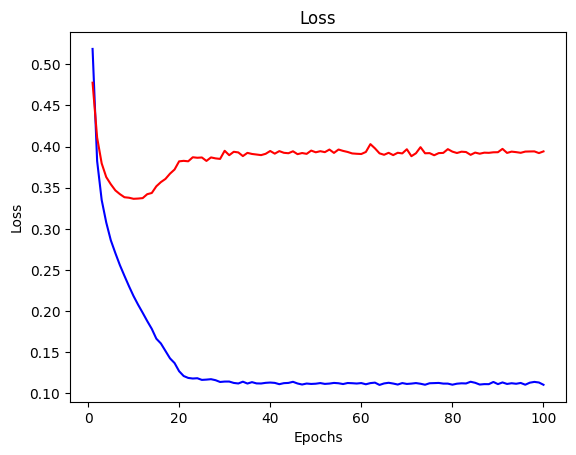

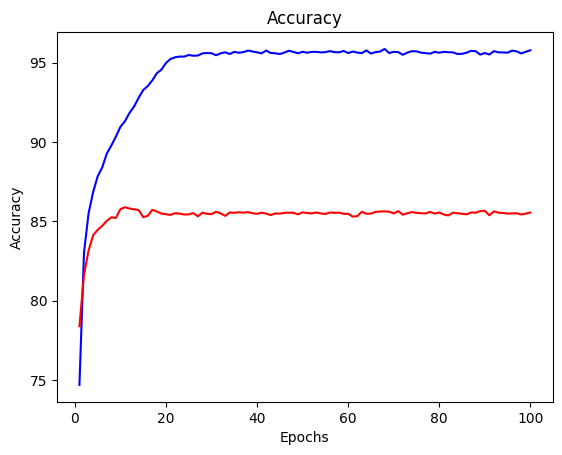

In [19]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Informativeness_Classification_EfficientNetb1_pretrained Confusion Matrix:

informative: 1, not_informative: 0


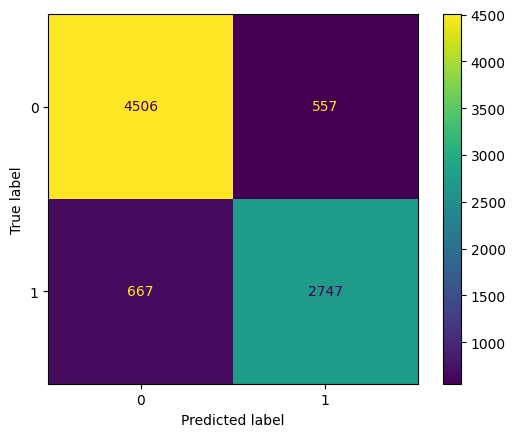

In [20]:
# "informative": 1, "not_informative": 0
print(task + '_EfficientNetb1_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# VGG16_pretrained

In [21]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [22]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [23]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_VGG16_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [24]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.3802 - accuracy: 82.59% - val_loss: 0.3648 - val_accuracy: 83.39% - time: 232.78s
Epoch 2/100 - loss: 0.2835 - accuracy: 87.80% - val_loss: 0.3453 - val_accuracy: 84.65% - time: 232.95s
Epoch 3/100 - loss: 0.2329 - accuracy: 90.28% - val_loss: 0.3436 - val_accuracy: 85.04% - time: 233.08s
Epoch 4/100 - loss: 0.1861 - accuracy: 92.41% - val_loss: 0.3538 - val_accuracy: 85.05% - time: 232.91s
Epoch 5/100 - loss: 0.1396 - accuracy: 94.41% - val_loss: 0.3815 - val_accuracy: 84.98% - time: 233.06s
Epoch 6/100 - loss: 0.1008 - accuracy: 96.19% - val_loss: 0.4297 - val_accuracy: 85.01% - time: 233.31s
Epoch 7/100 - loss: 0.0760 - accuracy: 97.31% - val_loss: 0.4413 - val_accuracy: 84.88% - time: 233.12s
Epoch 8/100 - loss: 0.0597 - accuracy: 97.87% - val_loss: 0.5111 - val_accuracy: 85.09% - time: 233.10s
Epoch 9/100 - loss: 0.0477 - accuracy: 98.36% - val_loss: 0.5364 - val_accuracy: 84.31% - time: 233.10s
Epoch 10/100 - loss: 0.0414 - accuracy: 98.56% - val_loss: 0.547

Epoch 80/100 - loss: 0.0114 - accuracy: 99.50% - val_loss: 0.8010 - val_accuracy: 84.91% - time: 233.54s
Epoch 81/100 - loss: 0.0116 - accuracy: 99.50% - val_loss: 0.8014 - val_accuracy: 84.92% - time: 233.47s
Epoch 82/100 - loss: 0.0119 - accuracy: 99.45% - val_loss: 0.8014 - val_accuracy: 84.91% - time: 233.49s
Epoch 83/100 - loss: 0.0118 - accuracy: 99.48% - val_loss: 0.8013 - val_accuracy: 84.91% - time: 233.67s
Epoch 84/100 - loss: 0.0112 - accuracy: 99.49% - val_loss: 0.8017 - val_accuracy: 84.90% - time: 233.32s
Epoch 85/100 - loss: 0.0118 - accuracy: 99.47% - val_loss: 0.8019 - val_accuracy: 84.90% - time: 233.76s
Epoch 86/100 - loss: 0.0118 - accuracy: 99.48% - val_loss: 0.8020 - val_accuracy: 84.91% - time: 233.87s
Epoch 87/100 - loss: 0.0117 - accuracy: 99.51% - val_loss: 0.8021 - val_accuracy: 84.91% - time: 233.78s
Epoch 88/100 - loss: 0.0119 - accuracy: 99.49% - val_loss: 0.8018 - val_accuracy: 84.95% - time: 233.51s
Epoch 89/100 - loss: 0.0116 - accuracy: 99.50% - val_lo

In [25]:
print(task + '_VGG16_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_VGG16_pretrained Classification Report:')
print(cr)

Informativeness_Classification_VGG16_pretrained Performance:
Accuracy : 85.26%
F1-Score : 85.02%
Informativeness_Classification_VGG16_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5063
           1       0.82      0.80      0.81      3414

    accuracy                           0.85      8477
   macro avg       0.84      0.84      0.84      8477
weighted avg       0.85      0.85      0.85      8477



## Visualize Results & Confusion Matrix

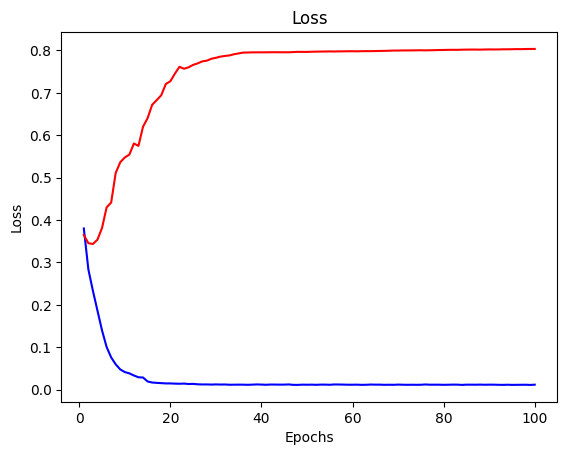

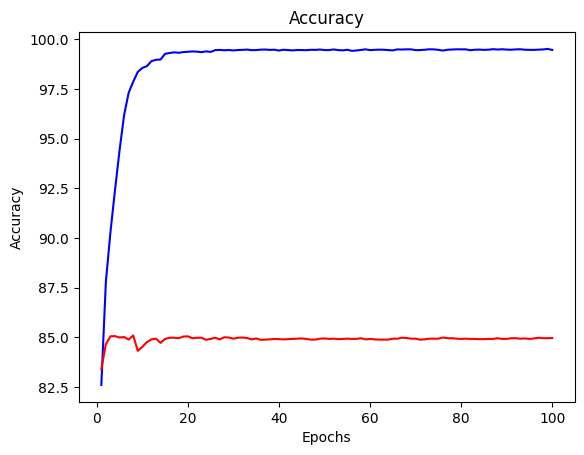

In [26]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Informativeness_Classification_VGG16_pretrained Confusion Matrix:

informative: 1, not_informative: 0


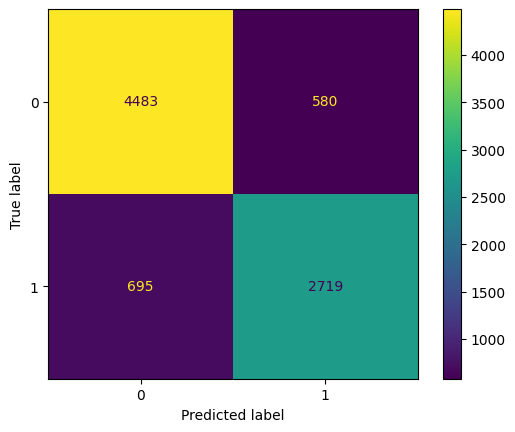

In [27]:
# "informative": 1, "not_informative": 0
print(task + '_VGG16_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet18_pretrained

In [28]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [29]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [30]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet18_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [31]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.3872 - accuracy: 82.16% - val_loss: 0.3879 - val_accuracy: 82.77% - time: 66.16s
Epoch 2/100 - loss: 0.2907 - accuracy: 87.68% - val_loss: 0.3670 - val_accuracy: 83.47% - time: 66.05s
Epoch 3/100 - loss: 0.2426 - accuracy: 90.11% - val_loss: 0.3621 - val_accuracy: 84.02% - time: 66.08s
Epoch 4/100 - loss: 0.2022 - accuracy: 92.05% - val_loss: 0.3703 - val_accuracy: 83.78% - time: 66.21s
Epoch 5/100 - loss: 0.1612 - accuracy: 93.98% - val_loss: 0.3865 - val_accuracy: 83.73% - time: 66.19s
Epoch 6/100 - loss: 0.1238 - accuracy: 95.84% - val_loss: 0.4171 - val_accuracy: 83.32% - time: 66.19s
Epoch 7/100 - loss: 0.0913 - accuracy: 97.23% - val_loss: 0.4472 - val_accuracy: 83.19% - time: 66.24s
Epoch 8/100 - loss: 0.0680 - accuracy: 98.07% - val_loss: 0.4831 - val_accuracy: 83.02% - time: 66.06s
Epoch 9/100 - loss: 0.0521 - accuracy: 98.57% - val_loss: 0.5095 - val_accuracy: 82.81% - time: 66.19s
Epoch 10/100 - loss: 0.0436 - accuracy: 98.80% - val_loss: 0.5425 - val_a

Epoch 80/100 - loss: 0.0125 - accuracy: 99.58% - val_loss: 0.6596 - val_accuracy: 82.61% - time: 66.30s
Epoch 81/100 - loss: 0.0124 - accuracy: 99.60% - val_loss: 0.6603 - val_accuracy: 82.67% - time: 66.43s
Epoch 82/100 - loss: 0.0123 - accuracy: 99.59% - val_loss: 0.6547 - val_accuracy: 83.04% - time: 66.47s
Epoch 83/100 - loss: 0.0123 - accuracy: 99.57% - val_loss: 0.6569 - val_accuracy: 82.80% - time: 66.59s
Epoch 84/100 - loss: 0.0119 - accuracy: 99.61% - val_loss: 0.6543 - val_accuracy: 82.84% - time: 66.31s
Epoch 85/100 - loss: 0.0120 - accuracy: 99.59% - val_loss: 0.6537 - val_accuracy: 83.06% - time: 66.62s
Epoch 86/100 - loss: 0.0122 - accuracy: 99.56% - val_loss: 0.6556 - val_accuracy: 82.93% - time: 66.78s
Epoch 87/100 - loss: 0.0119 - accuracy: 99.58% - val_loss: 0.6491 - val_accuracy: 83.10% - time: 66.60s
Epoch 88/100 - loss: 0.0129 - accuracy: 99.56% - val_loss: 0.6564 - val_accuracy: 82.88% - time: 66.53s
Epoch 89/100 - loss: 0.0117 - accuracy: 99.61% - val_loss: 0.656

In [32]:
print(task + '_ResNet18_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet18_pretrained Classification Report:')
print(cr)

Informativeness_Classification_ResNet18_pretrained Performance:
Accuracy : 84.16%
F1-Score : 83.95%
Informativeness_Classification_ResNet18_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      5063
           1       0.79      0.77      0.78      3414

    accuracy                           0.83      8477
   macro avg       0.82      0.82      0.82      8477
weighted avg       0.83      0.83      0.83      8477



## Visualize Results & Confusion Matrix

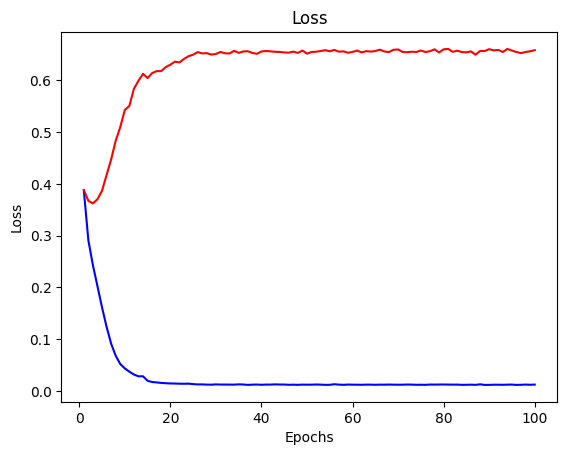

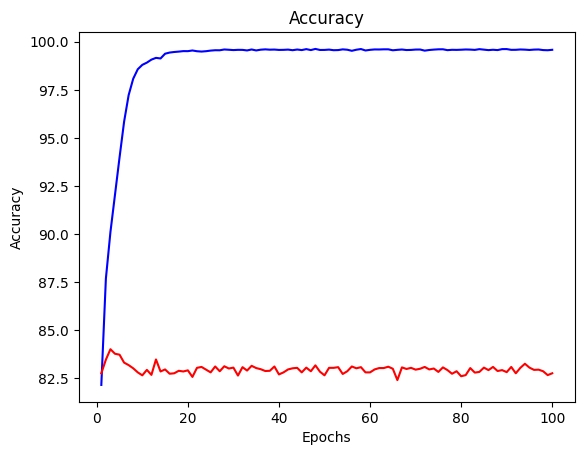

In [33]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Informativeness_Classification_ResNet18_pretrained Confusion Matrix:

informative: 1, not_informative: 0


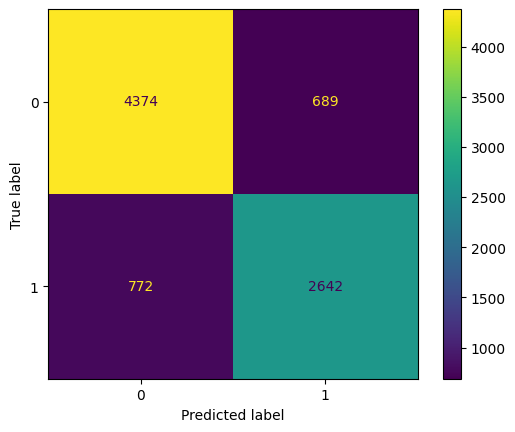

In [34]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet18_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet101_pretrained

In [35]:
model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [36]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [37]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet101_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [38]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.3324 - accuracy: 85.66% - val_loss: 0.3335 - val_accuracy: 85.53% - time: 255.64s
Epoch 2/100 - loss: 0.1945 - accuracy: 92.47% - val_loss: 0.3434 - val_accuracy: 85.47% - time: 255.53s
Epoch 3/100 - loss: 0.0987 - accuracy: 96.84% - val_loss: 0.3910 - val_accuracy: 84.81% - time: 255.79s
Epoch 4/100 - loss: 0.0565 - accuracy: 98.39% - val_loss: 0.4395 - val_accuracy: 85.02% - time: 255.73s
Epoch 5/100 - loss: 0.0401 - accuracy: 98.86% - val_loss: 0.4631 - val_accuracy: 85.31% - time: 254.85s
Epoch 6/100 - loss: 0.0326 - accuracy: 99.01% - val_loss: 0.4878 - val_accuracy: 84.79% - time: 254.07s
Epoch 7/100 - loss: 0.0273 - accuracy: 99.16% - val_loss: 0.5015 - val_accuracy: 84.64% - time: 254.25s
Epoch 8/100 - loss: 0.0243 - accuracy: 99.20% - val_loss: 0.5123 - val_accuracy: 85.31% - time: 253.77s
Epoch 9/100 - loss: 0.0220 - accuracy: 99.21% - val_loss: 0.5369 - val_accuracy: 85.04% - time: 253.97s
Epoch 10/100 - loss: 0.0197 - accuracy: 99.29% - val_loss: 0.541

Epoch 80/100 - loss: 0.0068 - accuracy: 99.68% - val_loss: 0.6368 - val_accuracy: 85.42% - time: 254.18s
Epoch 81/100 - loss: 0.0068 - accuracy: 99.68% - val_loss: 0.6399 - val_accuracy: 85.29% - time: 254.46s
Epoch 82/100 - loss: 0.0068 - accuracy: 99.68% - val_loss: 0.6462 - val_accuracy: 85.15% - time: 254.27s
Epoch 83/100 - loss: 0.0068 - accuracy: 99.68% - val_loss: 0.6356 - val_accuracy: 85.15% - time: 254.51s
Epoch 84/100 - loss: 0.0068 - accuracy: 99.67% - val_loss: 0.6428 - val_accuracy: 85.15% - time: 254.42s
Epoch 85/100 - loss: 0.0070 - accuracy: 99.70% - val_loss: 0.6484 - val_accuracy: 85.10% - time: 254.66s
Epoch 86/100 - loss: 0.0069 - accuracy: 99.68% - val_loss: 0.6377 - val_accuracy: 85.28% - time: 254.62s
Epoch 87/100 - loss: 0.0068 - accuracy: 99.69% - val_loss: 0.6492 - val_accuracy: 85.11% - time: 254.38s
Epoch 88/100 - loss: 0.0069 - accuracy: 99.69% - val_loss: 0.6354 - val_accuracy: 85.28% - time: 254.31s
Epoch 89/100 - loss: 0.0066 - accuracy: 99.70% - val_lo

In [39]:
print(task + '_ResNet101_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet101_pretrained Classification Report:')
print(cr)

Informativeness_Classification_ResNet101_pretrained Performance:
Accuracy : 85.65%
F1-Score : 85.44%
Informativeness_Classification_ResNet101_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      5063
           1       0.85      0.76      0.81      3414

    accuracy                           0.85      8477
   macro avg       0.85      0.84      0.84      8477
weighted avg       0.85      0.85      0.85      8477



## Visualize Results & Confusion Matrix

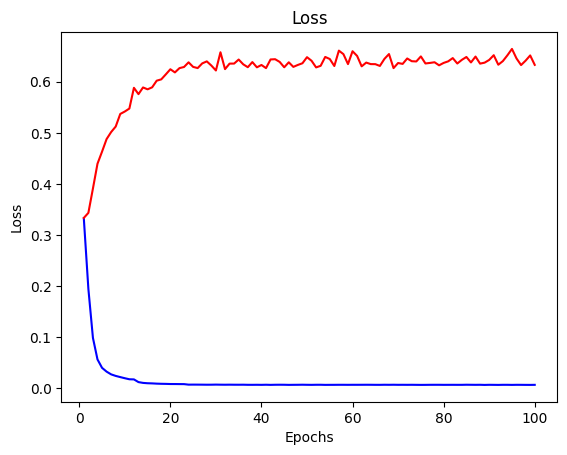

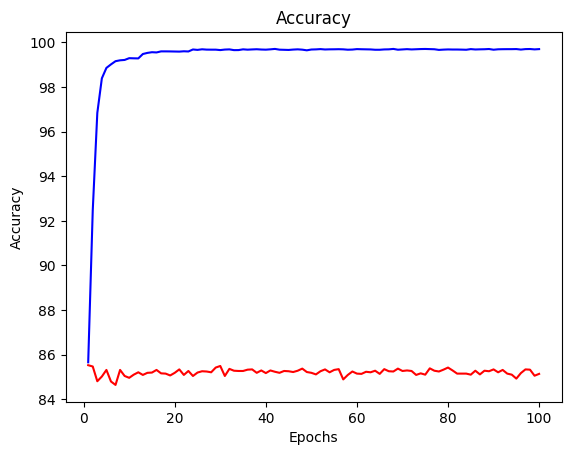

In [40]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Informativeness_Classification_ResNet101_pretrained Confusion Matrix:

informative: 1, not_informative: 0


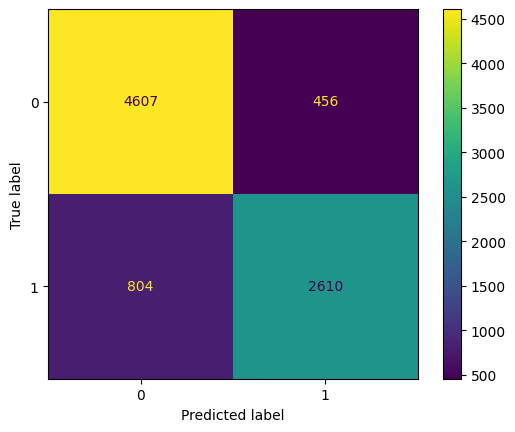

In [41]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet101_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# DenseNet121_pretrained

In [42]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [43]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [44]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_DenseNet121_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [45]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.4031 - accuracy: 81.55% - val_loss: 0.3862 - val_accuracy: 82.48% - time: 181.19s
Epoch 2/100 - loss: 0.2964 - accuracy: 87.26% - val_loss: 0.3542 - val_accuracy: 84.42% - time: 180.72s
Epoch 3/100 - loss: 0.2519 - accuracy: 89.70% - val_loss: 0.3424 - val_accuracy: 85.03% - time: 181.02s
Epoch 4/100 - loss: 0.2132 - accuracy: 91.53% - val_loss: 0.3429 - val_accuracy: 85.17% - time: 181.35s
Epoch 5/100 - loss: 0.1769 - accuracy: 93.27% - val_loss: 0.3492 - val_accuracy: 85.40% - time: 180.98s
Epoch 6/100 - loss: 0.1417 - accuracy: 94.83% - val_loss: 0.3730 - val_accuracy: 84.95% - time: 181.06s
Epoch 7/100 - loss: 0.1076 - accuracy: 96.44% - val_loss: 0.4051 - val_accuracy: 84.50% - time: 180.91s
Epoch 8/100 - loss: 0.0802 - accuracy: 97.49% - val_loss: 0.4325 - val_accuracy: 84.53% - time: 181.04s
Epoch 9/100 - loss: 0.0604 - accuracy: 98.24% - val_loss: 0.4788 - val_accuracy: 84.09% - time: 180.74s
Epoch 10/100 - loss: 0.0486 - accuracy: 98.55% - val_loss: 0.501

Epoch 80/100 - loss: 0.0112 - accuracy: 99.61% - val_loss: 0.6647 - val_accuracy: 83.92% - time: 180.92s
Epoch 81/100 - loss: 0.0107 - accuracy: 99.64% - val_loss: 0.6639 - val_accuracy: 83.70% - time: 180.16s
Epoch 82/100 - loss: 0.0109 - accuracy: 99.62% - val_loss: 0.6670 - val_accuracy: 83.76% - time: 180.59s
Epoch 83/100 - loss: 0.0107 - accuracy: 99.63% - val_loss: 0.6642 - val_accuracy: 83.80% - time: 180.71s
Epoch 84/100 - loss: 0.0109 - accuracy: 99.62% - val_loss: 0.6606 - val_accuracy: 83.87% - time: 180.79s
Epoch 85/100 - loss: 0.0109 - accuracy: 99.66% - val_loss: 0.6687 - val_accuracy: 83.90% - time: 180.98s
Epoch 86/100 - loss: 0.0110 - accuracy: 99.58% - val_loss: 0.6656 - val_accuracy: 83.80% - time: 180.35s
Epoch 87/100 - loss: 0.0111 - accuracy: 99.63% - val_loss: 0.6673 - val_accuracy: 83.85% - time: 180.61s
Epoch 88/100 - loss: 0.0109 - accuracy: 99.62% - val_loss: 0.6597 - val_accuracy: 83.83% - time: 180.53s
Epoch 89/100 - loss: 0.0108 - accuracy: 99.63% - val_lo

In [46]:
print(task + '_DenseNet121_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_DenseNet121_pretrained Classification Report:')
print(cr)

Informativeness_Classification_DenseNet121_pretrained Performance:
Accuracy : 85.56%
F1-Score : 85.33%
Informativeness_Classification_DenseNet121_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5063
           1       0.82      0.76      0.79      3414

    accuracy                           0.84      8477
   macro avg       0.83      0.83      0.83      8477
weighted avg       0.84      0.84      0.84      8477



## Visualize Results & Confusion Matrix

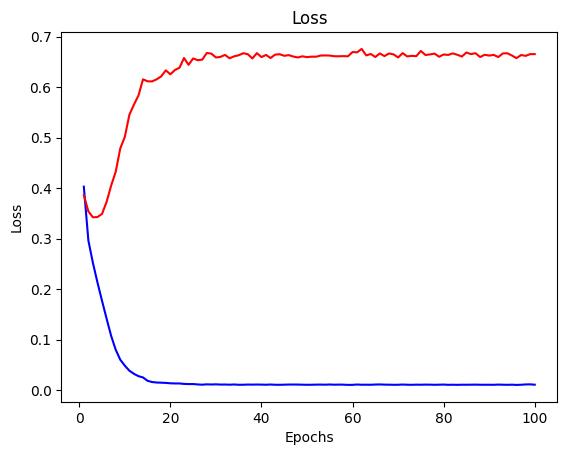

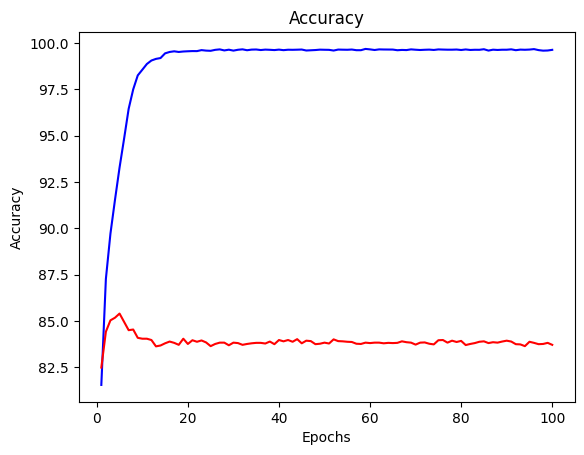

In [47]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Informativeness_Classification_DenseNet121_pretrained Confusion Matrix:

informative: 1, not_informative: 0


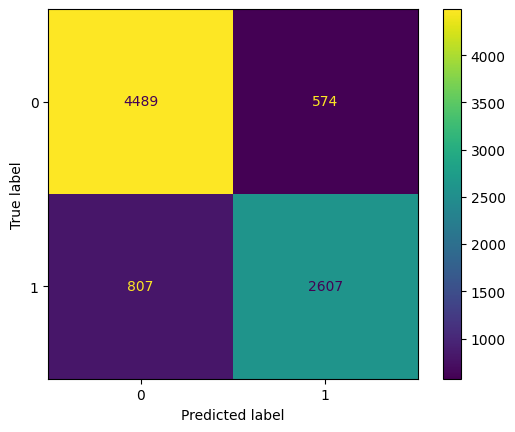

In [48]:
# "informative": 1, "not_informative": 0
print(task + '_DenseNet121_pretrained Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet 50_scratch

In [7]:
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [8]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [9]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/200 - loss: 1.1208 - accuracy: 67.57% - val_loss: 0.5840 - val_accuracy: 69.91% - time: 163.14s
Epoch 2/200 - loss: 0.5414 - accuracy: 74.07% - val_loss: 0.5764 - val_accuracy: 71.32% - time: 163.13s
Epoch 3/200 - loss: 0.5112 - accuracy: 75.13% - val_loss: 0.5728 - val_accuracy: 71.44% - time: 163.17s
Epoch 4/200 - loss: 0.4932 - accuracy: 76.05% - val_loss: 0.5571 - val_accuracy: 71.72% - time: 163.18s
Epoch 5/200 - loss: 0.4777 - accuracy: 76.94% - val_loss: 0.5679 - val_accuracy: 70.36% - time: 163.20s
Epoch 6/200 - loss: 0.4703 - accuracy: 77.43% - val_loss: 0.5654 - val_accuracy: 70.69% - time: 163.26s
Epoch 7/200 - loss: 0.4626 - accuracy: 77.90% - val_loss: 0.5327 - val_accuracy: 73.30% - time: 163.34s
Epoch 8/200 - loss: 0.4590 - accuracy: 78.20% - val_loss: 0.5331 - val_accuracy: 73.81% - time: 163.44s
Epoch 9/200 - loss: 0.4532 - accuracy: 78.53% - val_loss: 0.5279 - val_accuracy: 73.75% - time: 163.59s
Epoch 10/200 - loss: 0.4497 - accuracy: 78.71% - val_loss: 0.552

Epoch 80/200 - loss: 0.3738 - accuracy: 83.15% - val_loss: 0.5308 - val_accuracy: 74.42% - time: 163.51s
Epoch 81/200 - loss: 0.3730 - accuracy: 83.03% - val_loss: 0.5557 - val_accuracy: 76.15% - time: 163.57s
Epoch 82/200 - loss: 0.3765 - accuracy: 82.92% - val_loss: 0.5974 - val_accuracy: 71.15% - time: 163.48s
Epoch 83/200 - loss: 0.3722 - accuracy: 83.29% - val_loss: 0.5107 - val_accuracy: 74.76% - time: 163.87s
Epoch 84/200 - loss: 0.3724 - accuracy: 83.21% - val_loss: 0.5684 - val_accuracy: 72.34% - time: 163.70s
Epoch 85/200 - loss: 0.3707 - accuracy: 83.26% - val_loss: 0.8208 - val_accuracy: 71.40% - time: 163.44s
Epoch 86/200 - loss: 0.3702 - accuracy: 83.21% - val_loss: 0.6557 - val_accuracy: 71.90% - time: 163.51s
Epoch 87/200 - loss: 0.3668 - accuracy: 83.44% - val_loss: 0.5542 - val_accuracy: 72.91% - time: 163.61s
Epoch 88/200 - loss: 0.3697 - accuracy: 83.23% - val_loss: 0.5386 - val_accuracy: 72.71% - time: 163.60s
Epoch 89/200 - loss: 0.3685 - accuracy: 83.32% - val_lo

Epoch 158/200 - loss: 0.2961 - accuracy: 87.14% - val_loss: 0.6654 - val_accuracy: 73.58% - time: 163.82s
Epoch 159/200 - loss: 0.2997 - accuracy: 86.99% - val_loss: 0.5917 - val_accuracy: 71.30% - time: 163.42s
Epoch 160/200 - loss: 0.3005 - accuracy: 86.92% - val_loss: 0.8338 - val_accuracy: 70.20% - time: 163.76s
Epoch 161/200 - loss: 0.2955 - accuracy: 87.15% - val_loss: 0.7495 - val_accuracy: 71.55% - time: 163.45s
Epoch 162/200 - loss: 0.2954 - accuracy: 87.22% - val_loss: 0.6718 - val_accuracy: 73.88% - time: 163.39s
Epoch 163/200 - loss: 0.2971 - accuracy: 87.27% - val_loss: 0.6338 - val_accuracy: 70.58% - time: 163.34s
Epoch 164/200 - loss: 0.2915 - accuracy: 87.36% - val_loss: 0.6044 - val_accuracy: 73.72% - time: 163.53s
Epoch 165/200 - loss: 0.2950 - accuracy: 87.33% - val_loss: 0.6336 - val_accuracy: 72.93% - time: 163.29s
Epoch 166/200 - loss: 0.2927 - accuracy: 87.48% - val_loss: 0.5749 - val_accuracy: 72.88% - time: 163.39s
Epoch 167/200 - loss: 0.2940 - accuracy: 87.22

# print(task + '_ResNet50_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_scratch Classification Report:')
print(cr)

## Visualize Results & Confusion Matrix

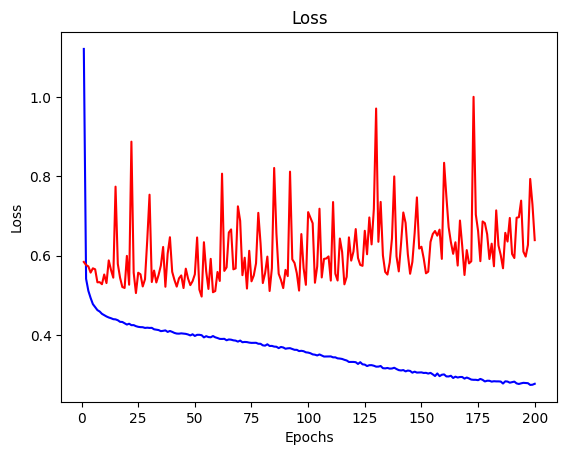

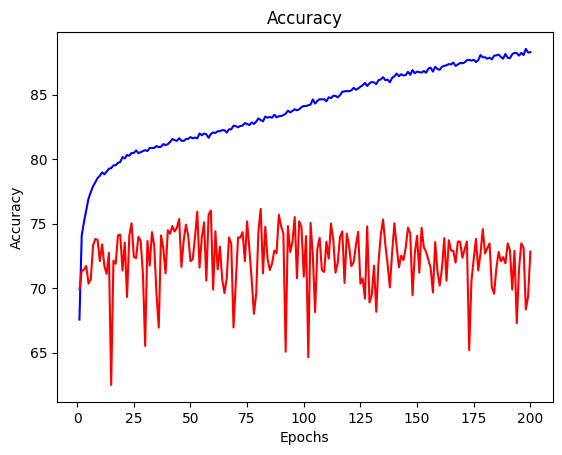

In [11]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Informativeness_Classification_ResNet50_scratch Confusion Matrix:

informative: 1, not_informative: 0


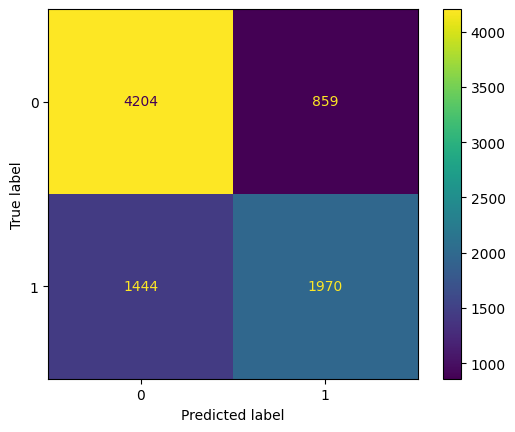

In [12]:
# "informative": 1, "not_informative": 0
print(task + '_ResNet50_scratch Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_scratch

In [13]:
model = models.efficientnet_b1(weights=None)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [14]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [15]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/200 - loss: 0.6685 - accuracy: 67.81% - val_loss: 0.6132 - val_accuracy: 67.03% - time: 137.15s
Epoch 2/200 - loss: 0.5593 - accuracy: 72.32% - val_loss: 0.5923 - val_accuracy: 68.90% - time: 136.94s
Epoch 3/200 - loss: 0.5358 - accuracy: 73.54% - val_loss: 0.6890 - val_accuracy: 65.27% - time: 137.07s
Epoch 4/200 - loss: 0.5107 - accuracy: 75.11% - val_loss: 0.6453 - val_accuracy: 62.11% - time: 137.02s
Epoch 5/200 - loss: 0.4917 - accuracy: 76.22% - val_loss: 0.5495 - val_accuracy: 72.05% - time: 136.73s
Epoch 6/200 - loss: 0.4803 - accuracy: 76.78% - val_loss: 0.6121 - val_accuracy: 71.39% - time: 137.35s
Epoch 7/200 - loss: 0.4728 - accuracy: 77.31% - val_loss: 0.6686 - val_accuracy: 67.37% - time: 139.17s
Epoch 8/200 - loss: 0.4708 - accuracy: 77.52% - val_loss: 0.8531 - val_accuracy: 73.10% - time: 138.59s
Epoch 9/200 - loss: 0.4669 - accuracy: 77.66% - val_loss: 0.9495 - val_accuracy: 73.32% - time: 138.58s
Epoch 10/200 - loss: 0.4670 - accuracy: 77.59% - val_loss: 0.823

Epoch 80/200 - loss: 0.4304 - accuracy: 79.86% - val_loss: 0.5736 - val_accuracy: 70.87% - time: 138.70s
Epoch 81/200 - loss: 0.4316 - accuracy: 79.82% - val_loss: 0.6300 - val_accuracy: 70.40% - time: 138.81s
Epoch 82/200 - loss: 0.4315 - accuracy: 79.79% - val_loss: 0.6239 - val_accuracy: 70.56% - time: 138.77s
Epoch 83/200 - loss: 0.4326 - accuracy: 79.75% - val_loss: 0.5749 - val_accuracy: 71.33% - time: 138.60s
Epoch 84/200 - loss: 0.4306 - accuracy: 79.91% - val_loss: 0.5330 - val_accuracy: 73.66% - time: 138.64s
Epoch 85/200 - loss: 0.4319 - accuracy: 79.69% - val_loss: 0.5432 - val_accuracy: 71.61% - time: 138.95s
Epoch 86/200 - loss: 0.4295 - accuracy: 79.82% - val_loss: 0.5665 - val_accuracy: 72.29% - time: 138.62s
Epoch 87/200 - loss: 0.4297 - accuracy: 80.04% - val_loss: 0.5778 - val_accuracy: 71.35% - time: 138.65s
Epoch 88/200 - loss: 0.4319 - accuracy: 79.66% - val_loss: 0.5892 - val_accuracy: 71.95% - time: 138.50s
Epoch 89/200 - loss: 0.4319 - accuracy: 79.80% - val_lo

Epoch 158/200 - loss: 0.4274 - accuracy: 80.14% - val_loss: 0.5207 - val_accuracy: 73.09% - time: 138.79s
Epoch 159/200 - loss: 0.4269 - accuracy: 80.17% - val_loss: 0.5124 - val_accuracy: 74.28% - time: 138.62s
Epoch 160/200 - loss: 0.4285 - accuracy: 80.01% - val_loss: 0.5711 - val_accuracy: 72.03% - time: 138.53s
Epoch 161/200 - loss: 0.4312 - accuracy: 79.69% - val_loss: 0.5500 - val_accuracy: 71.22% - time: 138.69s
Epoch 162/200 - loss: 0.4292 - accuracy: 79.95% - val_loss: 0.5060 - val_accuracy: 74.61% - time: 138.49s
Epoch 163/200 - loss: 0.4283 - accuracy: 79.91% - val_loss: 0.5078 - val_accuracy: 74.79% - time: 138.41s
Epoch 164/200 - loss: 0.4300 - accuracy: 79.84% - val_loss: 0.5350 - val_accuracy: 73.48% - time: 138.59s
Epoch 165/200 - loss: 0.4293 - accuracy: 79.82% - val_loss: 0.5181 - val_accuracy: 73.89% - time: 138.66s
Epoch 166/200 - loss: 0.4302 - accuracy: 79.90% - val_loss: 0.5975 - val_accuracy: 72.02% - time: 138.92s
Epoch 167/200 - loss: 0.4301 - accuracy: 79.77

In [16]:
print(task + '_EfficientNetb1_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_scratch Classification Report:')
print(cr)

Informativeness_Classification_EfficientNetb1_scratch Performance:
Accuracy : 75.99%
F1-Score : 75.89%
Informativeness_Classification_EfficientNetb1_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.94      0.80      5063
           1       0.81      0.40      0.53      3414

    accuracy                           0.72      8477
   macro avg       0.76      0.67      0.67      8477
weighted avg       0.74      0.72      0.69      8477



## Visualize Results & Confusion Matrix

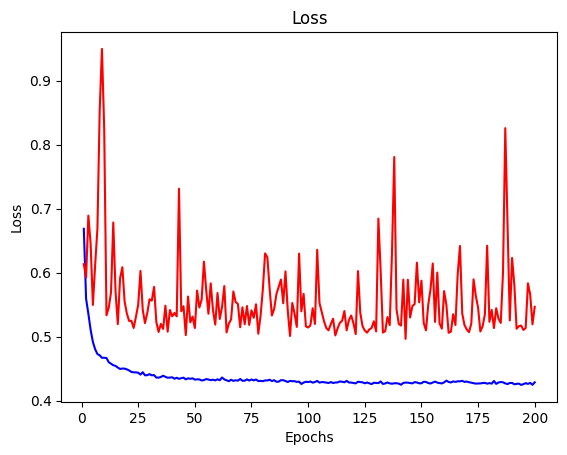

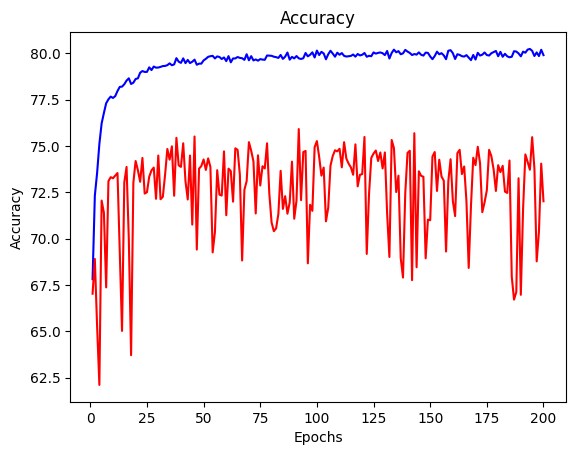

In [17]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Informativeness_Classification_EfficientNetb1_scratch Confusion Matrix:

informative: 1, not_informative: 0


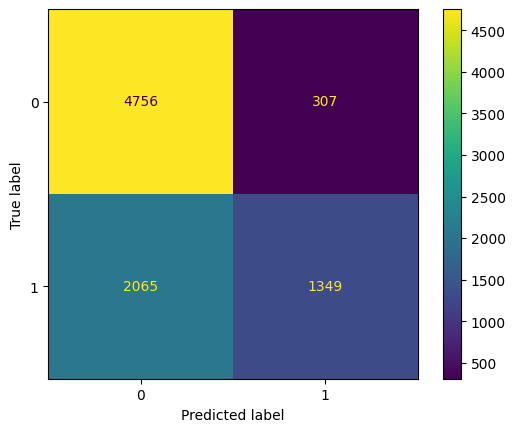

In [18]:
# "informative": 1, "not_informative": 0
print(task + '_EfficientNetb1_scratch Confusion Matrix:\n')
print('informative: 1, not_informative: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()